In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import albumentations as A
import os
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

# Machine Learning Model Comparison and Hyperparameter Tuning
This notebook compares several machine learning models on their ability to classify MRI Brain Tumor Photos.


It includes hyperparameter tuning for optimal performance.


# Model Implementation and Evaluation
We implement and evaluate the following models:


**SVM-Builtin**

**SVM_Soft_Margin_OVO_from_Scratch**

**K-Nearest Neighbors (KNN)**

**Decision Tree**

**Random Forest**

**Multi-Layer Perceptron (MLP)**



# Data Augmentation 

In [2]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
])

In [3]:
augmentation_path = '/kaggle/input/brain-tumor-classification-mri/Training/no_tumor'
output = '/kaggle/working/augmented_no_tumor' # Directory to save augmented images.

# to ensure the output directory exists
os.makedirs(output, exist_ok=True)

# Augmentation
for img in os.listdir(augmentation_path):
    image_path = os.path.join(augmentation_path, img)
    image = cv2.imread(image_path)
    augmented = transform(image=image)['image']
    
    # Save
    output_img_path = os.path.join(output, f"{os.path.splitext(img)[0]}_aug.jpg")
    # adding _aug suffix  to image name
    cv2.imwrite(output_img_path, augmented)

In [4]:
train_data = []
train_labels = []
test_data = []
test_labels = []

# Reading and prepare the Data

In [5]:
base_path = "/kaggle/input/brain-tumor-classification-mri"
augmented_path = "/kaggle/working"  #for augmented data

# Loop through Training and Testing directories
for dir in os.listdir(base_path):
    path = os.path.join(base_path, dir)  # Path to 'Training' or 'Testing'
    
    for sub_dir in os.listdir(path):  #each class
        sub_dir_path = os.path.join(path, sub_dir)  # path to subdirectory
        
        # Check if it's a valid directory
        if os.path.isdir(sub_dir_path):
            for img in os.listdir(sub_dir_path):  #each image in the subdirectory
                img_path = os.path.join(sub_dir_path, img)
                image = cv2.imread(img_path)
                if image is None:
                    continue  # Skip invalid files
                
                image = cv2.resize(image, (64, 64))  # Resize image
                image = image.flatten() / 255.0  # Normalize image
                
                # Append to appropriate list based on Training or Testing
                if dir == "Testing":
                    test_data.append(image)
                    test_labels.append(sub_dir) # Use subdirectory name as label
                else:  # For Training
                    train_data.append(image)
                    train_labels.append(sub_dir)

# Include augmented data from the /kaggle/working directory
augmented_no_tumor_path = os.path.join(augmented_path, "augmented_no_tumor")
if os.path.exists(augmented_no_tumor_path):
    for img in os.listdir(augmented_no_tumor_path):
        img_path = os.path.join(augmented_no_tumor_path, img)
        image = cv2.imread(img_path)
        if image is None:
            continue  # Skip invalid files
        
        image = cv2.resize(image, (64, 64))  # Resize image
        image = image.flatten() / 255.0  # Normalize image
        
        # Append augmented data under the 'no_tumor' label
        train_data.append(image)
        train_labels.append("no_tumor")  # Label as 'no_tumor'

# Convert to numpy arrays

In [6]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print(len(train_data), len(train_labels), len(test_data), len(test_labels))

3265 3265 394 394


# Data Preprocessing
1. **Principal Component Analysis (PCA):** Applied to reduce dimensionality and enhance computational efficiency.
2. **Data Splitting:** Split into training and validation sets to evaluate model generalization. 

In [7]:

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Split training data into train and validation sets
xtrain, xval, ytrain, yval = train_test_split(train_data, train_labels_encoded, test_size=0.2, random_state=42)

# Standardize the data (feature scaling)
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xval_scaled = scaler.transform(xval)
test_data_scaled = scaler.transform(test_data)  # Scale test data

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.98)  # Retain 98% variance
xtrain_pca = pca.fit_transform(xtrain_scaled)
xval_pca = pca.transform(xval_scaled)
test_data_pca = pca.transform(test_data_scaled)


# Built-in SVM

In [8]:

# Train the SVM model
svm = SVC(kernel='linear', random_state=42)  # You can experiment with 'rbf' kernel too
svm.fit(xtrain_pca, ytrain)

# Validate the model on validation data
yval_pred = svm.predict(xval_pca)
print("Validation Accuracy:", accuracy_score(yval, yval_pred))
print(classification_report(yval, yval_pred, target_names=label_encoder.classes_))

# Test the model on unseen test data
ytest_pred = svm.predict(test_data_pca)
print("Test Accuracy:", accuracy_score(test_labels_encoded, ytest_pred))

f1 = f1_score(test_labels_encoded, ytest_pred, average='weighted')
recall = recall_score(test_labels_encoded, ytest_pred, average='weighted')
precision = precision_score(test_labels_encoded, ytest_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(classification_report(test_labels_encoded, ytest_pred, target_names=label_encoder.classes_))


Validation Accuracy: 0.8039816232771823
                  precision    recall  f1-score   support

    glioma_tumor       0.76      0.86      0.81       150
meningioma_tumor       0.66      0.64      0.65       158
        no_tumor       0.89      0.72      0.80       174
 pituitary_tumor       0.89      0.99      0.94       171

        accuracy                           0.80       653
       macro avg       0.80      0.80      0.80       653
    weighted avg       0.81      0.80      0.80       653

Test Accuracy: 0.6675126903553299
F1 Score: 0.6333
Recall: 0.6675
Precision: 0.7397
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.23      0.37       100
meningioma_tumor       0.68      0.82      0.74       115
        no_tumor       0.58      0.93      0.72       105
 pituitary_tumor       0.76      0.65      0.70        74

        accuracy                           0.67       394
       macro avg       0.75      0.66      0.63       394
 

# Hyper parameter tunning for SVM 

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, n_jobs=-1)
grid.fit(xtrain_pca, ytrain)
print(grid.best_params_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


In [10]:
svm = SVC(kernel='linear',gamma= 1, C=0.1, random_state=42)  # You can experiment with 'rbf' kernel too
svm.fit(xtrain_pca, ytrain)
ytest_pred = svm.predict(test_data_pca)
print("Test Accuracy:", accuracy_score(test_labels_encoded, ytest_pred))

Test Accuracy: 0.6675126903553299


# SVM From Scratch

In [11]:
from cvxopt import matrix, solvers
from itertools import combinations
from sklearn.metrics import accuracy_score, classification_report

In [12]:
class SVM:
    def __init__(self, C=1.0):
        self.C = C  # Soft margin parameter
        #A larger value of𝐶 means 
        #the model penalizes misclassifications more
        self.w = None  # Weight vector
        self.b = 0     # Bias term

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Compute the Gram matrix (dot product between pairs of samples)
        #computes pairwise dot products of all input vectors
        K = np.dot(X, X.T)

        # Setup the QP(Quadratic Programming) problem
        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones((n_samples, 1)))
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), self.C * np.ones(n_samples))))
        A = matrix(y.reshape(1, -1), tc='d')
        b = matrix(0.0)

        # Solve the QP problem
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x']).flatten()

        # Support vectors have non-zero alphas
        support_vector_idx = alphas > 1e-5
        self.alphas = alphas[support_vector_idx]
        self.support_vectors = X[support_vector_idx]
        self.support_vector_labels = y[support_vector_idx]

        # Compute weight vector
        self.w = np.sum(self.alphas[:, np.newaxis] * self.support_vector_labels[:, np.newaxis] * self.support_vectors, axis=0)

        # Compute bias
        self.b = np.mean(
            self.support_vector_labels - np.dot(self.support_vectors, self.w)
        )

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

In [13]:
class OvO_SVM:
    def __init__(self, C=1.0):
        self.C = C
        self.models = {} # dictionary to store binary SVM models
        self.classes = None # Unique class labels

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.models = {}

        # Train binary SVMs for each pair of classes
        for (class1, class2) in combinations(self.classes, 2):
            print(f"Training for {class1} vs {class2}")
            X_binary = X[np.logical_or(y == class1, y == class2)]
            y_binary = y[np.logical_or(y == class1, y == class2)]
            y_binary = np.where(y_binary == class1, 1, -1)

            model = SVM(C=self.C)
            model.fit(X_binary, y_binary)
            self.models[(class1, class2)] = model

    def predict(self, X):
        votes = np.zeros((X.shape[0], len(self.classes)))

        # Get predictions from all binary classifiers
        for (class1, class2), model in self.models.items():
            predictions = model.predict(X)
            votes[:, self.classes.tolist().index(class1)] += predictions == 1
            votes[:, self.classes.tolist().index(class2)] += predictions == -1

        # Class with the most votes wins
        return self.classes[np.argmax(votes, axis=1)]

In [14]:
ovo_svm = OvO_SVM(C=1.0)
ovo_svm.fit(xtrain_pca, ytrain)



Training for 0 vs 1
     pcost       dcost       gap    pres   dres
 0: -5.3874e+01 -2.2853e+03  1e+04  2e+00  1e-11
 1: -2.8497e+01 -1.2307e+03  3e+03  4e-01  8e-12
 2: -3.6837e+00 -3.3731e+02  6e+02  8e-02  6e-12
 3: -1.7213e-01 -8.0647e+01  1e+02  1e-02  2e-12
 4:  1.8915e-01 -2.7097e+01  4e+01  4e-03  6e-13
 5:  8.4836e-02 -1.2658e+01  2e+01  1e-03  3e-13
 6: -4.4644e-02 -5.1175e+00  6e+00  3e-04  1e-13
 7: -1.8499e-01 -2.6237e+00  3e+00  1e-04  9e-14
 8: -3.1690e-01 -7.5126e-01  4e-01  7e-06  8e-14
 9: -3.7541e-01 -5.0852e-01  1e-01  1e-06  7e-14
10: -3.9970e-01 -4.2799e-01  3e-02  2e-07  7e-14
11: -4.0614e-01 -4.0962e-01  3e-03  2e-08  7e-14
12: -4.0702e-01 -4.0739e-01  4e-04  2e-09  6e-14
13: -4.0712e-01 -4.0714e-01  2e-05  6e-11  7e-14
14: -4.0713e-01 -4.0713e-01  3e-07  9e-13  7e-14
Optimal solution found.
Training for 0 vs 2
     pcost       dcost       gap    pres   dres
 0: -8.0998e+00 -1.9315e+03  1e+04  2e+00  8e-12
 1: -3.4103e+00 -8.7634e+02  2e+03  3e-01  5e-12
 2: -2.

In [15]:
# Validate the model on validation data
yval_pred = ovo_svm.predict(xval_pca)
print("Validation Accuracy:", accuracy_score(yval, yval_pred))
print(classification_report(yval, yval_pred, target_names=label_encoder.classes_))

# Test the model on unseen test data
ytest_pred = ovo_svm.predict(test_data_pca)
print("Test Accuracy:", accuracy_score(test_labels_encoded, ytest_pred))
print(classification_report(test_labels_encoded, ytest_pred, target_names=label_encoder.classes_))

Validation Accuracy: 0.8039816232771823
                  precision    recall  f1-score   support

    glioma_tumor       0.76      0.86      0.81       150
meningioma_tumor       0.66      0.64      0.65       158
        no_tumor       0.89      0.72      0.80       174
 pituitary_tumor       0.89      0.99      0.94       171

        accuracy                           0.80       653
       macro avg       0.80      0.80      0.80       653
    weighted avg       0.81      0.80      0.80       653

Test Accuracy: 0.6675126903553299
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.23      0.37       100
meningioma_tumor       0.68      0.82      0.74       115
        no_tumor       0.58      0.93      0.72       105
 pituitary_tumor       0.76      0.65      0.70        74

        accuracy                           0.67       394
       macro avg       0.74      0.66      0.63       394
    weighted avg       0.74      0.67      0.63    

# KNN Model

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(xtrain_pca, ytrain)

# Predict on the test set
knn_predictions = knn.predict(test_data_pca)


print("Test Accuracy:", accuracy_score(test_labels_encoded, knn_predictions))
f1 = f1_score(test_labels_encoded, knn_predictions, average='weighted')
recall = recall_score(test_labels_encoded, knn_predictions, average='weighted')
precision = precision_score(test_labels_encoded, knn_predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(classification_report(test_labels_encoded, knn_predictions, target_names=label_encoder.classes_))


Test Accuracy: 0.4619289340101523
F1 Score: 0.4404
Recall: 0.4619
Precision: 0.5296
                  precision    recall  f1-score   support

    glioma_tumor       0.46      0.27      0.34       100
meningioma_tumor       0.73      0.28      0.40       115
        no_tumor       0.39      0.82      0.53       105
 pituitary_tumor       0.51      0.50      0.51        74

        accuracy                           0.46       394
       macro avg       0.52      0.47      0.44       394
    weighted avg       0.53      0.46      0.44       394



# Decision Tree and Random Forest 

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

# Define a function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)
    return accuracy, f1, recall, precision, report

# Decision Tree
decision_tree = DecisionTreeClassifier(max_depth=10)
decision_tree_metrics = evaluate_model(decision_tree, xtrain_pca, ytrain, test_data_pca, test_labels_encoded)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100, max_depth=10)
random_forest_metrics = evaluate_model(random_forest, xtrain_pca, ytrain, test_data_pca, test_labels_encoded)

# Print the comparison report
models = ['Decision Tree', 'Random Forest']
metrics = [decision_tree_metrics, random_forest_metrics]

for model, metric in zip(models, metrics):
    accuracy, f1, recall, precision, report = metric
    print(f"Model: {model}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Classification Report:\n{report}")
    print("\n" + "="*60 + "\n")

Model: Decision Tree
Accuracy: 0.5838
F1 Score: 0.5457
Recall: 0.5838
Precision: 0.5744
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.21      0.31       100
           1       0.62      0.83      0.71       115
           2       0.58      0.83      0.68       105
           3       0.51      0.36      0.43        74

    accuracy                           0.58       394
   macro avg       0.57      0.56      0.53       394
weighted avg       0.57      0.58      0.55       394



Model: Random Forest
Accuracy: 0.6447
F1 Score: 0.6169
Recall: 0.6447
Precision: 0.6314
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.23      0.31       100
           1       0.76      0.83      0.79       115
           2       0.58      0.88      0.70       105
           3       0.70      0.59      0.64        74

    accuracy                           0.64       394
   macro avg   

# Multi-Layer Perceptron (MLP)

In [18]:
from sklearn.neural_network import MLPClassifier

# For MLP
mlp = MLPClassifier()
mlp.fit(xtrain_pca, ytrain)
y_pred = mlp.predict(test_data_pca)
print(accuracy_score(test_labels_encoded, y_pred))
print("\nClassification Report:\n", classification_report(test_labels_encoded, y_pred))

0.6649746192893401

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.16      0.27       100
           1       0.71      0.86      0.78       115
           2       0.57      0.97      0.72       105
           3       0.80      0.61      0.69        74

    accuracy                           0.66       394
   macro avg       0.72      0.65      0.61       394
weighted avg       0.71      0.66      0.62       394



# Function for tune the models parameters

In [19]:
from sklearn.model_selection import GridSearchCV

def tune_model(model, param_grid, X_train, y_train):
    """
    Performs GridSearchCV to find the best hyperparameters for the given model.

    Args:
        model: The machine learning model to tune.
        param_grid: Dictionary containing hyperparameters and their possible values.
        X_train: Training feature data.
        y_train: Training labels.

    Returns:
        The model with the best parameters from GridSearchCV.
    """
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best Parameters: {grid_search.best_params_}")  # Print the best hyperparameters
    print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")  # Display best score
    
    return grid_search.best_estimator_  # Return the tuned model


## eplanation of some notes on tune model function 

**cv=5:** This sets up 5-fold cross-validation, meaning the training data is split into 5 parts, and the model is trained 5 times, each time using a different part as a validation set.

**verbose=1:** Controls the verbosity level. 1 will show messages about the progress of the search.


**n_jobs=-1:** Uses all available CPUs for parallel processing, speeding up the search process.

## parameter tuning for MLP
hidden_layer_sizes: Number of neurons in each hidden layer.

activation: Activation function for hidden layers.

alpha: Regularization term to prevent overfitting.

In [20]:
# Define Hyperparameter Grid for MLP
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Tuning MLP
best_mlp = tune_model(MLPClassifier(max_iter=500), mlp_params, xtrain_pca, ytrain)

# Evaluate the Tuned MLP Model
mlp_predictions = best_mlp.predict(test_data_pca)
print(classification_report(test_labels_encoded, mlp_predictions))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50)}
Best Cross-Validation Accuracy: 0.8002
              precision    recall  f1-score   support

           0       0.82      0.23      0.36       100
           1       0.79      0.86      0.82       115
           2       0.55      0.96      0.70       105
           3       0.84      0.64      0.72        74

    accuracy                           0.69       394
   macro avg       0.75      0.67      0.65       394
weighted avg       0.74      0.69      0.65       394



## parameter tune for random forest 

n_estimators: Number of trees in the forest. More trees improve 
performance but increase computation time.

max_depth: Depth of each tree (affects overfitting/underfitting).

min_samples_split: Minimum samples to split a node (regularization).

In [21]:
# Define Hyperparameter Grid for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Tuning Random Forest
best_rf = tune_model(RandomForestClassifier(), rf_params, xtrain_pca, ytrain)

# Evaluate the Tuned Random Forest Model
rf_predictions = best_rf.predict(test_data_pca)
print(classification_report(test_labels_encoded, rf_predictions))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.7653
              precision    recall  f1-score   support

           0       0.67      0.24      0.35       100
           1       0.84      0.83      0.83       115
           2       0.51      0.95      0.66       105
           3       0.81      0.53      0.64        74

    accuracy                           0.65       394
   macro avg       0.71      0.64      0.62       394
weighted avg       0.70      0.65      0.63       394



# display the output of the MLP model (Best Accuracy)

In [22]:
import os
import matplotlib.pyplot as plt
import cv2
import math

def get_test_image_paths_and_labels(test_dir):
    """
    Fetches the image paths and true labels from the Testing directory.

    Args:
        test_dir (str): Path to the Testing directory.

    Returns:
        list, list: Lists of image paths and their corresponding true labels.
    """
    image_paths = []
    true_labels = []
    
    for label_dir in os.listdir(test_dir):  # Iterate through class folders
        label_path = os.path.join(test_dir, label_dir)
        if os.path.isdir(label_path):  # Ensure it's a directory
            for img_name in os.listdir(label_path):  # Iterate through images
                image_paths.append(os.path.join(label_path, img_name))
                true_labels.append(label_dir)  # Use folder name as the true label

    return image_paths, true_labels


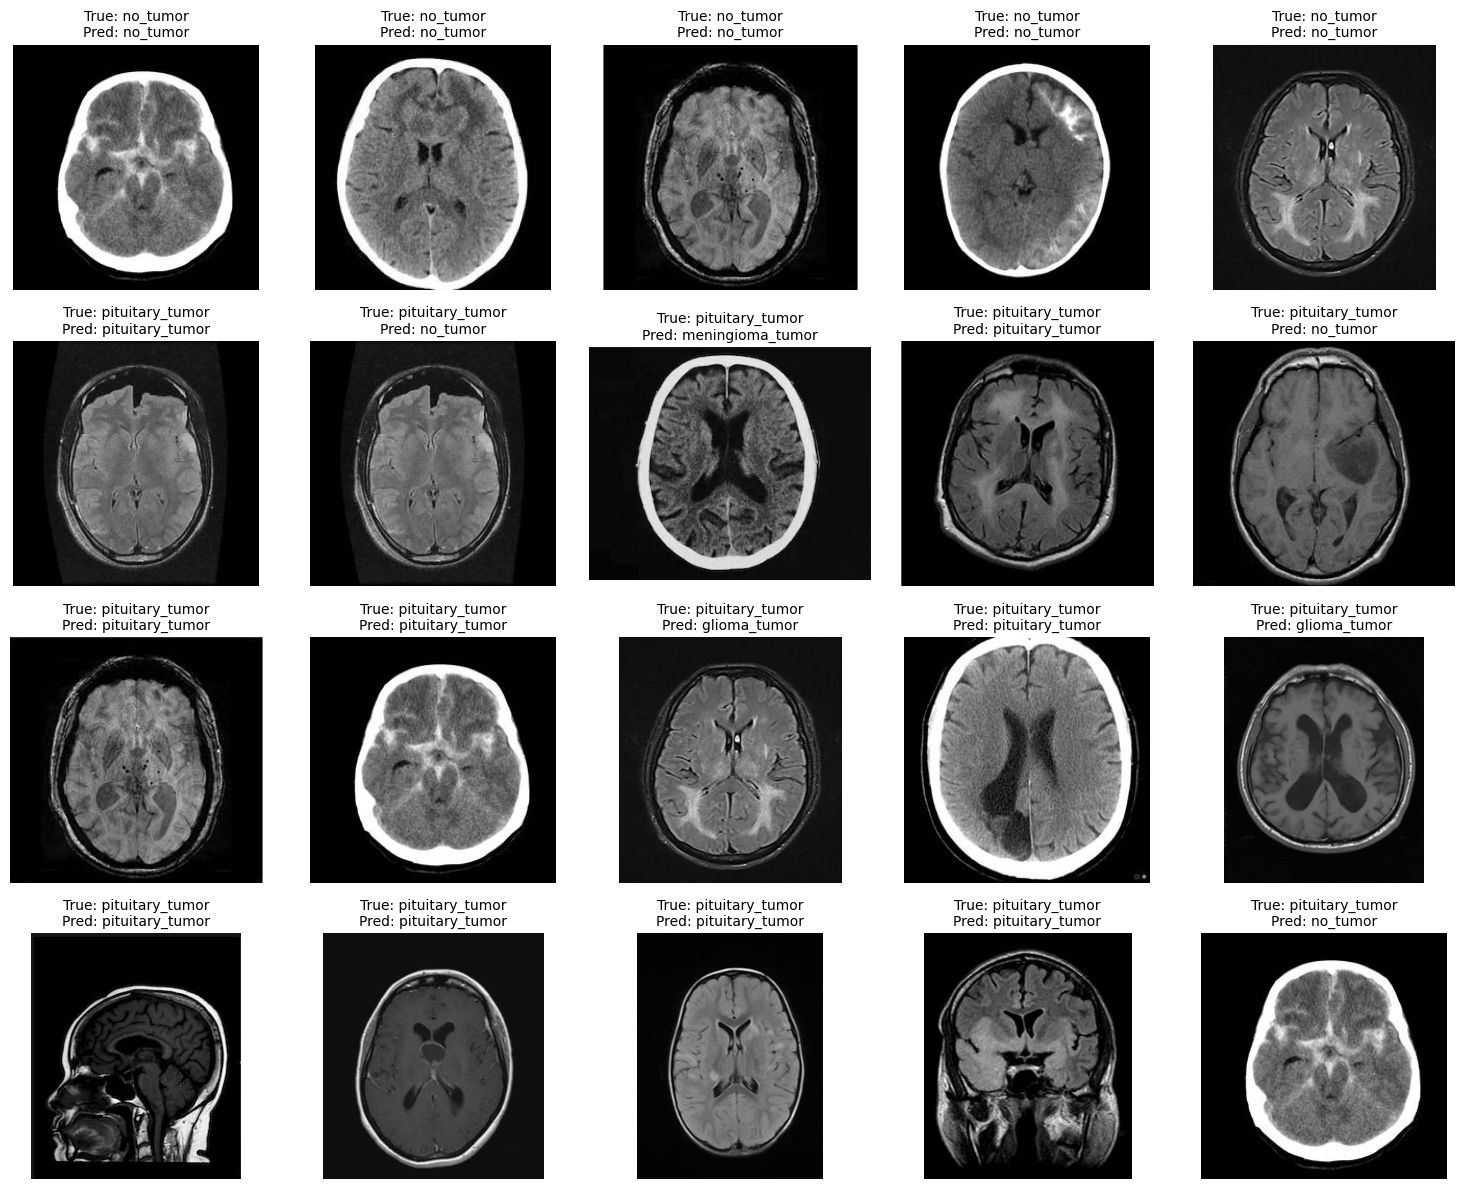

In [23]:
import math
import os
import matplotlib.pyplot as plt
import cv2

def display_grayscale_images_with_predictions_multirow(image_paths, true_labels, predicted_labels, num_images=10, images_per_row=5):
    """
    Displays grayscale images with their true and predicted labels in multiple rows.

    Args:
        image_paths (list): List of paths to the grayscale images.
        true_labels (list): True labels of the images.
        predicted_labels (list): Predicted labels of the images.
        num_images (int): Number of images to display.
        images_per_row (int): Number of images to display per row.
    """
    num_rows = math.ceil(num_images / images_per_row)
    plt.figure(figsize=(images_per_row * 3, num_rows * 3))  # Adjust figure size for readability
    
    for i in range(min(num_images, len(image_paths))):
        image = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
        
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]
        
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(image, cmap='gray')  # Display as grayscale
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Path to Testing directory
test_dir = "/kaggle/input/brain-tumor-classification-mri/Testing"

# Fetch test images and their true labels
test_image_paths, true_labels = get_test_image_paths_and_labels(test_dir)

# Displaying the images in multiple rows
subset_size = 20  # Number of images to display
images_per_row = 5  # Number of images per row

# Make sure to use the subset of paths and labels
selected_image_paths = test_image_paths[:subset_size]# Select a subset of image paths
predicted_labels = label_encoder.inverse_transform(mlp_predictions)
predicted_labels_subset = predicted_labels[100:100+subset_size]  # Update with predictions
true_labels_subset = true_labels[100:100+subset_size]

display_grayscale_images_with_predictions_multirow(selected_image_paths, true_labels_subset, predicted_labels_subset, num_images=subset_size, images_per_row=images_per_row)


In [24]:
predicted_labels

array(['no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'meningioma_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'meningioma_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no

# Analyze predictions across the entire test set

In [25]:

from collections import Counter


# Count occurrences of each predicted label
label_counts = Counter(predicted_labels)

# Print the counts and proportions
total_predictions = sum(label_counts.values())
print("Predicted Label Distribution:")
for label, count in label_counts.items():
    proportion = count / total_predictions
    print(f"{label}: {count} ({proportion:.2%})")


Predicted Label Distribution:
no_tumor: 185 (46.95%)
meningioma_tumor: 125 (31.73%)
pituitary_tumor: 56 (14.21%)
glioma_tumor: 28 (7.11%)
